# Clean Up Task

### Overview
This notebook demonstrates single- and multi-agent planning in a cooperative cleanup task using sophisticated active inference and Theory of Mind (ToM) capabilities.

### Task Description
The cleanup task occurs in a 3×3 grid environment. Agents must eat apples that spawn in the orchard, but apples only spawn when the river is sufficiently clean. The river becomes polluted at a set rate, requiring agents to balance cleaning the river with eating apples.

### Key Features Demonstrated
Note that all agents conduct planning via sophisticated inference and we use the `another_works_for_tom` branch of pymdp.

1. **Single non-ToM Agent** - uses the `pymdp` rollout function.

2. **Optimized Single non-ToM Agent** - uses our custom rollout function with planning tree recycling for improved performance.

3. **Multiple non-ToM Agents** - uses our custom rollout function with planning tree recycling that also supports multiple agents in one shared environment.

4. **Single ToM Agent with Multiple non-ToM Agents** - one agent planning with theory of mind capabilities alongside two agents without theory of mind capabilities. Uses our custom rollout function which accommodates both planning strategies, planning tree recycling, and multiple agents in one shared environment. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr

import matplotlib.pyplot as plt

from tom.envs import CleanUpEnv
from tom.models import CleanUpModel, CleanUpAgent
from tom.planning.visualize import visualize_plan_tree, visualize_beliefs, visualize_env

from tom.planning.si import si_policy_search as si_policy_search_nontom
from tom.planning.si_tom import si_policy_search_tom, ToMify

from pymdp.envs import rollout as rollout_pymdp
from tom.planning.rollout_deprecated import rollout as rollout_optimized
from tom.planning.rollout_tom_deprecated import rollout as rollout_tom

# Single Non-ToM Agent

Initialize the environment

In [3]:
grid_size = 3
pollution_rate = 0.2
num_agents = 1
initial_positions = jnp.array([4]) # can set to None and it will be initialised randomly

env = CleanUpEnv(pollution_rate, num_agents, grid_size, initial_positions) 

/var/folders/m1/2n727yx90pn_hq1lr6drrkxc0000gn/T/ipykernel_52696/3678801692.py:6: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  env = CleanUpEnv(pollution_rate, num_agents, grid_size, initial_positions)


Initialize the agent

In [4]:
gamma = 1.0

model = CleanUpModel(pollution_rate=pollution_rate)
agents = CleanUpAgent(model, gamma=gamma, batch_size=num_agents)

Running the agent using the sophisticated inference non-tom planning (`si_policy_search_nontom`) and the `pymdp` rollout function

In [5]:
horizon=7
max_nodes = 10000
max_branching = 7
policy_prune_threshold = 1 / 8
observation_prune_threshold = 1 / 8
entropy_stop_threshold = 0.5
efe_stop_threshold = 5
kl_threshold=1e-2
prune_penalty = 512 

# set up the policy search function
tree_search_nontom = si_policy_search_nontom(
        horizon=horizon,
        max_nodes=max_nodes,
        max_branching=max_branching,
        policy_prune_threshold=policy_prune_threshold,
        observation_prune_threshold=observation_prune_threshold,
        entropy_stop_threshold=entropy_stop_threshold,
        efe_stop_threshold=efe_stop_threshold,
        kl_threshold=kl_threshold,
        prune_penalty=prune_penalty,
        gamma=gamma
    )

In [6]:
T = 10
key = jr.PRNGKey(1)
last, info_single_nontom, env = rollout_pymdp(agents, env, T, key, policy_search=tree_search_nontom)

/Users/riddhi/Documents/Projects/ToM/tom/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/riddhi/Documents/Projects/ToM/tom/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/riddhi/Documents/Projects/ToM/tom/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/

In [7]:
visualize_env(info_single_nontom, model=model, save_as_gif=False, gif_filename="cleanup_single_nontom.gif")

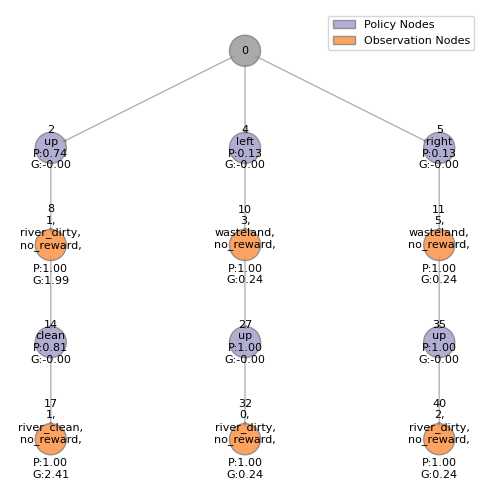

In [8]:
visualize_plan_tree(info_single_nontom, time_idx=0, agent_idx=0, model=model, min_prob=0.0, depth=4, fig_size=(5,5))

In [9]:
# visualize_beliefs(info_single_nontom, model=model)

# Optimized Single Non-ToM Agent

The environment, agent, and planning algorithm set up are the same as above. We now just run the agent using the our custom rollout function function which recycles the planning tree for better performance. 

In [10]:
T = 10
key = jr.PRNGKey(1)
last, info_optimized_single_nontom, env = rollout_optimized(agents, env, T, key, policy_search=tree_search_nontom)

/Users/riddhi/Documents/Projects/ToM/tom/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/riddhi/Documents/Projects/ToM/tom/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/riddhi/Documents/Projects/ToM/tom/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/rid

In [11]:
visualize_env(info_optimized_single_nontom, model=model, save_as_gif=False, gif_filename="cleanup_optimized_single_nontom.gif")

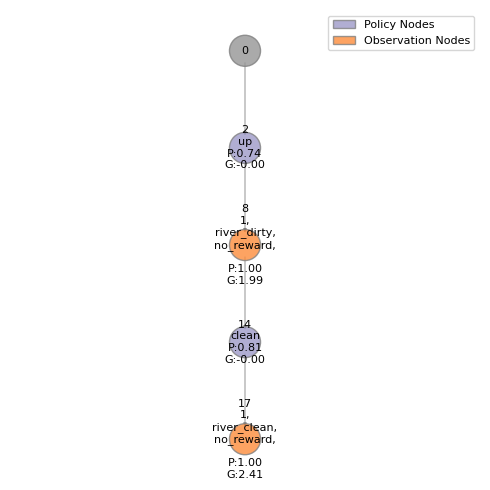

In [12]:
visualize_plan_tree(info_optimized_single_nontom, time_idx=0, agent_idx=0, model=model, depth=4, fig_size=(5,5))

In [13]:
# visualize_beliefs(info_optimized_single_nontom, model=model)

# Mulitple non-ToM Agents

Initialize the environment

In [14]:
grid_size = 3
pollution_rate = 0.2
num_agents = 3
initial_positions = jnp.array([7, 5, 1]) # can set to None and it will be initialised randomly

env = CleanUpEnv(pollution_rate, num_agents, grid_size, initial_positions) 

/var/folders/m1/2n727yx90pn_hq1lr6drrkxc0000gn/T/ipykernel_52696/383119726.py:6: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  env = CleanUpEnv(pollution_rate, num_agents, grid_size, initial_positions)


Initialize the agents

In [15]:
gamma = 1.0

model = CleanUpModel(pollution_rate=pollution_rate)
agents = CleanUpAgent(model, gamma=gamma, batch_size=num_agents)

The planning algorithm set up is the same as above. We now just run the agent using the our custom rollout function function which, in addition to recycling the planning tree for better performance, allows multiple agents to be in a shared environment. 

In [16]:
T = 10
key = jr.PRNGKey(1)
last, info_optimized_multi_nontom, env = rollout_optimized(agents, env, T, key,
                        policy_search=tree_search_nontom)

/Users/riddhi/Documents/Projects/ToM/tom/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/riddhi/Documents/Projects/ToM/tom/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/riddhi/Documents/Projects/ToM/tom/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/rid

In [17]:
visualize_env(info_optimized_multi_nontom, model=model, save_as_gif=False, gif_filename="cleanup_optimized_multi_nontom.gif")

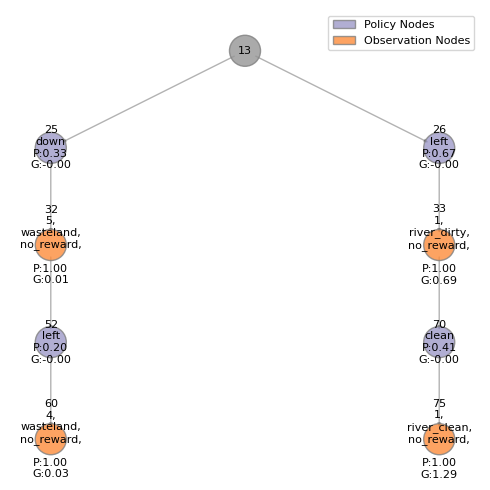

In [18]:
visualize_plan_tree(info_optimized_multi_nontom, time_idx=2, agent_idx=1, model=model, depth=4, fig_size=(5,5))

In [19]:
# visualize_beliefs(info_optimized_multi_nontom, model=model)

# Single ToM Agent with Multiple non-ToM Agents

Initialize the agents

In [20]:
agent0 = CleanUpAgent(model, gamma=gamma, batch_size=1)
focal_agent = ToMify(agent0,
                     self_states=[0, 1],
                     world_states=[2, 3, 4, 5, 6, 7],
                     observation_mappings=jnp.array([[[0,1,2],[3,-1,-1],[4,-1,-1]]]))

# note that observations from the environment include the locations of the other agents so we have observation mappings that tell us which observation is regarding which agent (-1s are invalid)

other_agents = CleanUpAgent(model, gamma=gamma, batch_size=2)

Running the agent using the sophisticated inference planning with theory of mind capabilities (`si_policy_search_tom`) and the custom rollout function which allows non-ToM and ToM agents to interact within the same environment.

In [21]:
tree_search_tom = si_policy_search_tom(
            horizon=horizon,
            max_nodes=max_nodes,
            max_branching=max_branching,
            policy_prune_threshold=policy_prune_threshold,
            observation_prune_threshold=observation_prune_threshold,
            entropy_stop_threshold=entropy_stop_threshold,
            efe_stop_threshold=efe_stop_threshold,
            kl_threshold=kl_threshold,
            prune_penalty=prune_penalty,
            gamma=gamma,
        )

In [ ]:
key = jr.PRNGKey(1)
T=10

last, info_tom, env = rollout_tom(focal_agent,
            other_agents,
            env,
            T,
            key,
            other_agent_policy_search=tree_search_nontom,
            focal_agent_tom_policy_search=tree_search_tom,
)

/Users/riddhi/Documents/Projects/ToM/tom/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/riddhi/Documents/Projects/ToM/tom/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/riddhi/Documents/Projects/ToM/tom/.venv/lib/python3.11/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/rid

In [ ]:
visualize_env(info_tom, model=model, save_as_gif=True, gif_filename="cleanup_tom.gif")

In [ ]:
# visualize_plan_tree(info_tom, time_idx=2, agent_idx=1, model=model, depth=4, fig_size=(5,5))

In [ ]:
# visualize_beliefs(info_tom, model=model)